# Notebook TFM Experimentación
<div style="background-color:#F2EDED;">
<br/>
<div>
<img src="https://uploads-ssl.webflow.com/614b1fe22fa8b90ef41aeffe/6265cb48f9496b1cefc9ab75_logotipo-mbit-39.png" width="200px" align="left" CLASS="TextWrap" style="background-color:#2a3f3f; margin-left: 10px;">
<img src="https://branding-guidelines.msf.es/esp/imgs/logo/Logo-01.jpg" width="100px" align="right" CLASS="TextWrap" style="background-color:#2a3f3f;">
</div>
<br/>
<br/>
<br/>
<div>
<h1><font color="#2a3f3f" size=4 style="margin-left: 10px;">MODELO DE PROBABILIDAD A TESTAR EN MÉDICOS SIN FRONTERAS</font></h1>
</div>
<br/>
<div style="text-align: right; margin-right: 10px; margin-bottom: 10px;">
<font color="#2a3f3f" size=3>Elio López Salamanca </font><br>
<font color="#2a3f3f" size=3>Sergio Israel Calleja Chimeno</font><br>
</div>
</div>

En este proyecto vamos a generar un caso de uso que ayude a MSF a detectar socios potenciales que puedan
dejar el testamento a favor de MSF.

En este notebook vamos a hacer los entrenamientos necesarios para proponer el modelo más eficiente para
que prediga si el socio potencialmente puede dejar dicho testamento a favor

Este notebook consiste en los siguientes pasos

1. **Lectura de datos**: lectura de los datos anteriormente preprocesados
2. **Generacion datos entrenamiento y test**: generamos datos de entrenamiento y test
3. **Entrenamiento modelo base**: entrenamos y evaluamos un modelo base
4. **Enfoques alternativos**: entrenamos y evaluamos modelos alternativos
4. **Busqueda de hiperparametros**: optimizamos nuestro modelo para buscar mayor precisión

## Imports e instalables necesarios

In [2]:
%%capture --no-display
!pip install -U imbalanced-learn==0.8.1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import pickle

## Leemos los datos preprocesados

In [4]:
df_preprocessed = pd.read_parquet("msf_df_preprocessed.parquet")
df_preprocessed.shape

(687224, 97)

## Preparación de datos
- Se hace la división entre dato de entrenamiento y test
- Vemos la distribución de clases entre tiene programa herencias o no lo tiene

In [5]:
def create_training_sets(data, list_columns):
    """
    Convert data frame to train, validation and test
    params:
        data: The dataframe with the dataset to be split
    Returns:
        train_features: Training feature dataset
        test_features: Test feature dataset 
        train_labels: Labels for the training dataset
        test_labels: Labels for the test dataset
        val_features: Validation feature dataset
        val_labels: Labels for the validation dataset
    """
    # Extract the target variable from the dataframe and convert the type to float32
    ys = np.array(data["cnt_programaherencias"]).astype("float32")
    
    # Drop all the unwanted columns including the target column
    drop_list = ["cnt_id", "cnt_programaherencias"]
    data = data[list_columns]
    
    # Drop the columns from the drop_list and convert the data into a NumPy array of type float32
    xs = np.array(data.drop(drop_list, axis=1)).astype("float32")
    
    np.random.seed(0)
    
    # Use the sklearn function train_test_split to split the dataset in the ratio train 80% and test 20%
    train_features, test_features, \
    train_labels, test_labels = train_test_split(xs, ys, test_size=0.2, stratify=ys)
    
    
    return train_features, test_features, train_labels, test_labels

In [6]:
# Use the function to create your datasets
train_features, test_features, train_labels, test_labels = create_training_sets(df_preprocessed, df_preprocessed.columns)

print(f"Length of train_features is: {train_features.shape}")
print(f"Length of train_labels is: {train_labels.shape}")
print(f"Length of test_features is: {test_features.shape}")
print(f"Length of test_labels is: {test_labels.shape}")

Length of train_features is: (549779, 95)
Length of train_labels is: (549779,)
Length of test_features is: (137445, 95)
Length of test_labels is: (137445,)


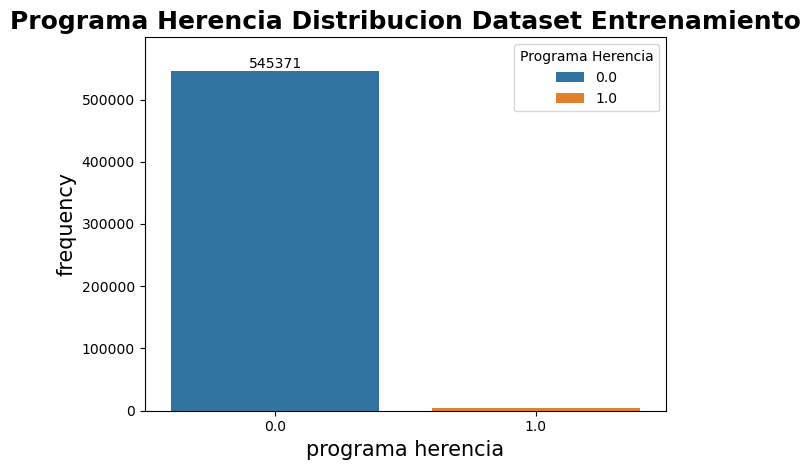

In [7]:
df = pd.DataFrame(data=train_labels, columns=["Programa Herencia"])
ax = sns.countplot(x="Programa Herencia", hue="Programa Herencia", dodge=False, data=df)
ax.set_title("Programa Herencia Distribucion Dataset Entrenamiento", fontsize=18, fontweight='bold')
ax.set_xlabel('programa herencia', fontsize=15,)
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_ylabel('frequency', fontsize=15)
ax.margins(y=0.1)

plt.tight_layout()
plt.show()

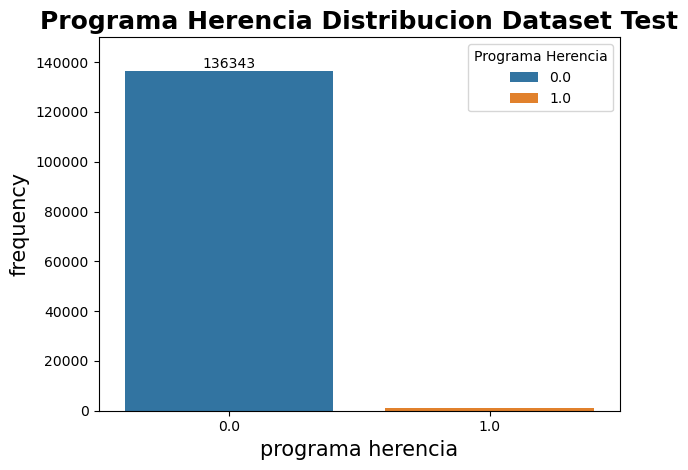

In [8]:
df = pd.DataFrame(data=test_labels, columns=["Programa Herencia"])
ax = sns.countplot(x="Programa Herencia", hue="Programa Herencia", dodge=False, data=df)
ax.set_title("Programa Herencia Distribucion Dataset Test", fontsize=18, fontweight='bold')
ax.set_xlabel('programa herencia', fontsize=15,)
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_ylabel('frequency', fontsize=15)
ax.margins(y=0.1)

plt.tight_layout()
plt.show()

## Modelo Base
Generamos un modelo base, es decir sin hacer optimizaciones para 4 clasificadores:
- Regresión Logistica
- Gaussian Naive Bayes
- Random Forest Classifier
- MLP Classifier

Haremos una pipeline de normalización de datos y ejecución del modelo

### REGRESIÓN LOGÍSTICA
- Modelo baseline

#### Entrenamiento

In [9]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('lf', LogisticRegression(random_state = 0))])

In [10]:
train_pipeline.fit(train_features, train_labels)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()),
                ('lf', LogisticRegression(random_state=0))])

#### Evaluacion

In [11]:
y_pred  = train_pipeline.predict(test_features)

In [12]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    136343
         1.0       0.93      0.55      0.69      1102

    accuracy                           1.00    137445
   macro avg       0.96      0.77      0.84    137445
weighted avg       1.00      1.00      1.00    137445



In [13]:
confusion_matrix(test_labels, y_pred)

array([[136297,     46],
       [   497,    605]])

In [14]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                            136297   
Programa Herencias                                  497   

                       Predicción Programa Herencias  
No Programa Herencias                             46  
Programa Herencias                               605  


In [15]:
accuracy_score(test_labels, y_pred)

0.996049328822438

In [16]:
roc_auc_score(test_labels, y_pred)

0.7743322152455974

In [17]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

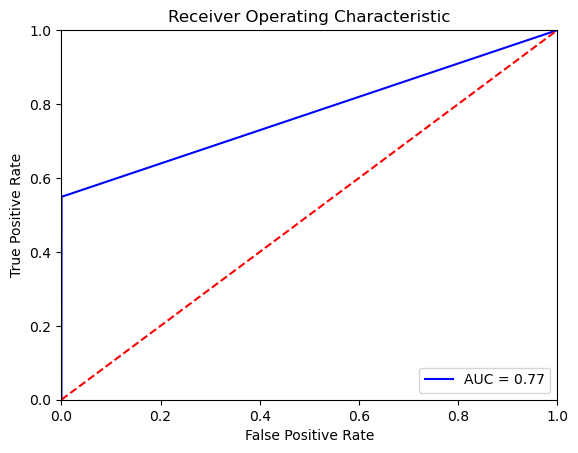

In [18]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### NB

#### Entrenamiento

In [19]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('gb', GaussianNB())])

In [20]:
train_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('scaler', StandardScaler()), ('gb', GaussianNB())])

#### Evaluacion

In [21]:
y_pred  = train_pipeline.predict(test_features)

In [22]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98    136343
         1.0       0.12      0.45      0.19      1102

    accuracy                           0.97    137445
   macro avg       0.56      0.71      0.59    137445
weighted avg       0.99      0.97      0.98    137445



In [23]:
confusion_matrix(test_labels, y_pred)

array([[132718,   3625],
       [   610,    492]])

In [24]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                            132718   
Programa Herencias                                  610   

                       Predicción Programa Herencias  
No Programa Herencias                           3625  
Programa Herencias                               492  


In [25]:
accuracy_score(test_labels, y_pred)

0.969187675070028

In [26]:
roc_auc_score(test_labels, y_pred)

0.7099368115748111

In [27]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

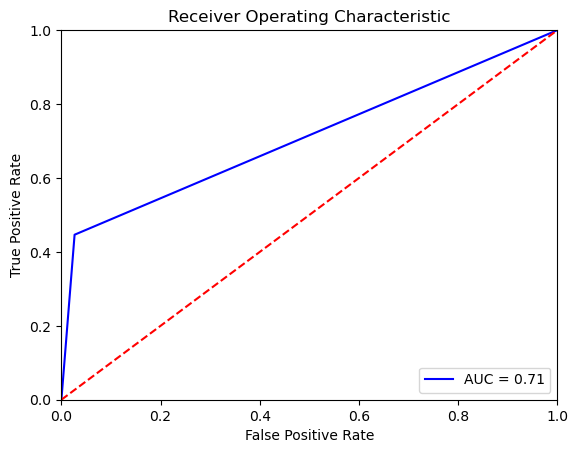

In [28]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### RF Classifier

#### Entrenamiento

In [29]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(max_depth=2, random_state=0))])

In [30]:
train_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(max_depth=2, random_state=0))])

#### Evaluacion

In [31]:
y_pred  = train_pipeline.predict(test_features)

In [32]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    136343
         1.0       0.00      0.00      0.00      1102

    accuracy                           0.99    137445
   macro avg       0.50      0.50      0.50    137445
weighted avg       0.98      0.99      0.99    137445



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
confusion_matrix(test_labels, y_pred)

array([[136343,      0],
       [  1102,      0]])

In [34]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                            136343   
Programa Herencias                                 1102   

                       Predicción Programa Herencias  
No Programa Herencias                              0  
Programa Herencias                                 0  


In [35]:
accuracy_score(test_labels, y_pred)

0.9919822474444323

In [36]:
roc_auc_score(test_labels, y_pred)

0.5

In [37]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

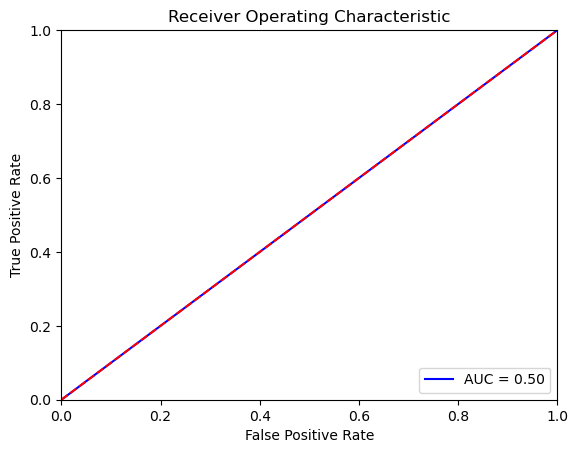

In [38]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### MLP Classifier
- Modelo baseline

#### Entrenamiento

In [39]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(random_state=0, max_iter=25))])

In [40]:
train_pipeline.fit(train_features, train_labels)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=25, random_state=0))])

#### Evaluacion

In [41]:
y_pred  = train_pipeline.predict(test_features)

In [42]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    136343
         1.0       0.92      0.63      0.75      1102

    accuracy                           1.00    137445
   macro avg       0.96      0.81      0.87    137445
weighted avg       1.00      1.00      1.00    137445



In [43]:
confusion_matrix(test_labels, y_pred)

array([[136285,     58],
       [   411,    691]])

In [44]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                            136285   
Programa Herencias                                  411   

                       Predicción Programa Herencias  
No Programa Herencias                             58  
Programa Herencias                               691  


In [45]:
accuracy_score(test_labels, y_pred)

0.9965877259994907

In [46]:
roc_auc_score(test_labels, y_pred)

0.8133081722882822

In [47]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

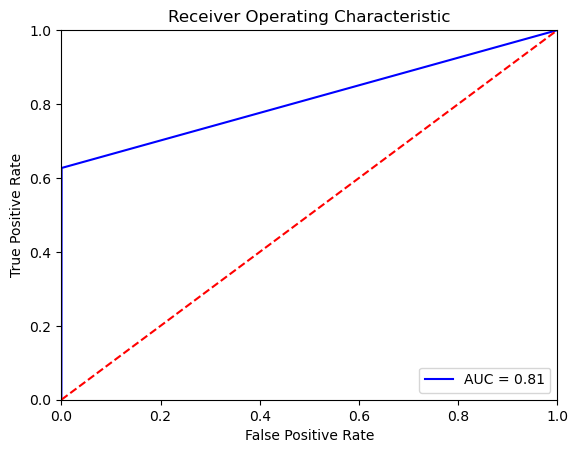

In [48]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Conclusiones
- Se detecta un desbalanceo de clases, que hace que el modelo tienda a predecir que no tiene programa herencias.
- Parece que funciona mejor una regresión logistica, ya que es menos sensible a desbalanceos de datos

## Tratamiento desbalanceo de clases

### Eliminar registros clase mayoritaria

#### Generamos dataset

In [49]:
variables_salida_bal = list(df_preprocessed.columns)
variables_salida_bal.remove("cnt_id")
variables_salida_bal.remove("cnt_programaherencias")

In [50]:
# Select the rows in df_train dataframe where Target == 1
data_to_balanced_df = pd.DataFrame(train_features, columns = variables_salida_bal)
data_to_balanced_df['Target'] = train_labels

herencias_df = data_to_balanced_df[data_to_balanced_df['Target'] == 1]

# Select the rows in df_train dataframe where Target == 0
non_herencias_df = data_to_balanced_df[data_to_balanced_df['Target'] == 0].sample(herencias_df.shape[0], random_state=235)

balanced_df = pd.concat([herencias_df, non_herencias_df], ignore_index=True, sort=False)

balanced_df.head()

,cnt_programais,cmp_isemergency,opp_rating_Caliente,opp_rating_Frio,opp_rating_Templado,opp_stagename_Cobrada,opp_stagename_Puesta al cobro,opp_program_Conversion prospectos,opp_program_Cultivacion socios MASS,opp_program_Cultivacion socios MID,...,cmp_status_Created,cmp_status_In Progress,rcd_installmentperiod_Bimensual,rcd_installmentperiod_Monthly,rcd_installmentperiod_Quarterly,rcd_installmentperiod_Semestral,rcd_installmentperiod_Yearly,opp_type_Membership,opp_type_Recurrent Donation,Target
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'Balanced Distribution of the dataset')

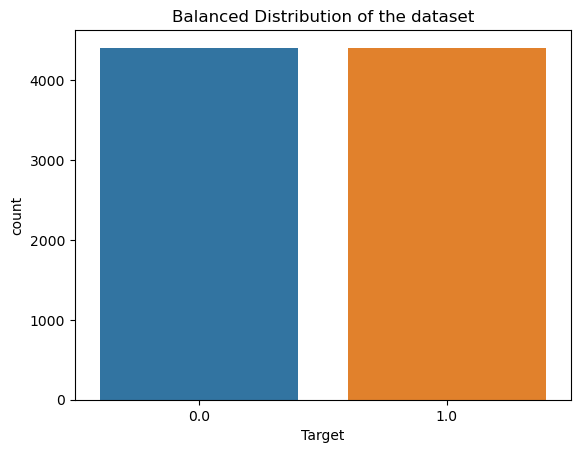

In [51]:
sns.countplot(x=balanced_df["Target"])
plt.title('Balanced Distribution of the dataset')

In [52]:
balanced_df.shape

(8816, 96)

#### REGRESIÓN LOGÍSTICA

##### Entrenamiento

In [53]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('lf', LogisticRegression(random_state = 0))])

In [54]:
train_pipeline.fit(balanced_df.drop(["Target"], axis=1), balanced_df["Target"])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()),
                ('lf', LogisticRegression(random_state=0))])

##### Evaluacion

In [55]:
y_pred  = train_pipeline.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [56]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    136343
         1.0       0.06      0.85      0.12      1102

    accuracy                           0.90    137445
   macro avg       0.53      0.87      0.53    137445
weighted avg       0.99      0.90      0.94    137445



In [57]:
confusion_matrix(test_labels, y_pred)

array([[122637,  13706],
       [   167,    935]])

In [58]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                            122637   
Programa Herencias                                  167   

                       Predicción Programa Herencias  
No Programa Herencias                          13706  
Programa Herencias                               935  


In [59]:
accuracy_score(test_labels, y_pred)

0.8990650805776856

In [60]:
roc_auc_score(test_labels, y_pred)

0.8739657353445611

In [61]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

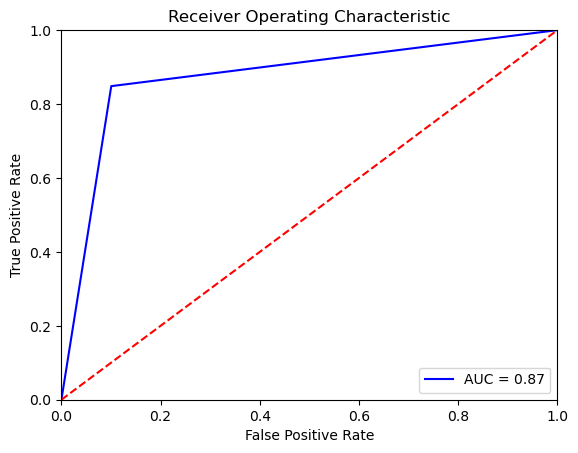

In [62]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### NB

##### Entrenamiento

In [63]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('gb', GaussianNB())])

In [64]:
train_pipeline.fit(balanced_df.drop(["Target"], axis=1), balanced_df["Target"])

Pipeline(steps=[('scaler', StandardScaler()), ('gb', GaussianNB())])

##### Evaluacion

In [65]:
y_pred  = train_pipeline.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [66]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    136343
         1.0       0.17      0.39      0.24      1102

    accuracy                           0.98    137445
   macro avg       0.58      0.69      0.61    137445
weighted avg       0.99      0.98      0.98    137445



In [67]:
confusion_matrix(test_labels, y_pred)

array([[134263,   2080],
       [   672,    430]])

In [68]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                            134263   
Programa Herencias                                  672   

                       Predicción Programa Herencias  
No Programa Herencias                           2080  
Programa Herencias                               430  


In [69]:
accuracy_score(test_labels, y_pred)

0.9799774455236641

In [70]:
roc_auc_score(test_labels, y_pred)

0.6874719975015505

In [71]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

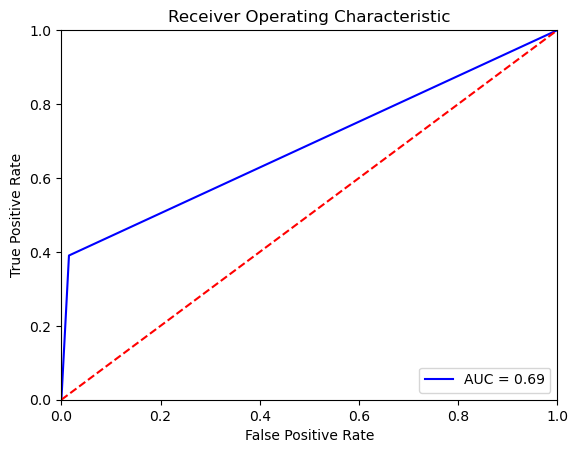

In [72]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### RF Classifier

##### Entrenamiento

In [73]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(max_depth=2, random_state=0))])

In [74]:
train_pipeline.fit(balanced_df.drop(["Target"], axis=1), balanced_df["Target"])

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(max_depth=2, random_state=0))])

##### Evaluacion

In [75]:
y_pred  = train_pipeline.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [76]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    136343
         1.0       0.11      0.70      0.18      1102

    accuracy                           0.95    137445
   macro avg       0.55      0.83      0.58    137445
weighted avg       0.99      0.95      0.97    137445



In [77]:
confusion_matrix(test_labels, y_pred)

array([[129761,   6582],
       [   326,    776]])

In [78]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                            129761   
Programa Herencias                                  326   

                       Predicción Programa Herencias  
No Programa Herencias                           6582  
Programa Herencias                               776  


In [79]:
accuracy_score(test_labels, y_pred)

0.9497398959583834

In [80]:
roc_auc_score(test_labels, y_pred)

0.8279494615061063

In [81]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

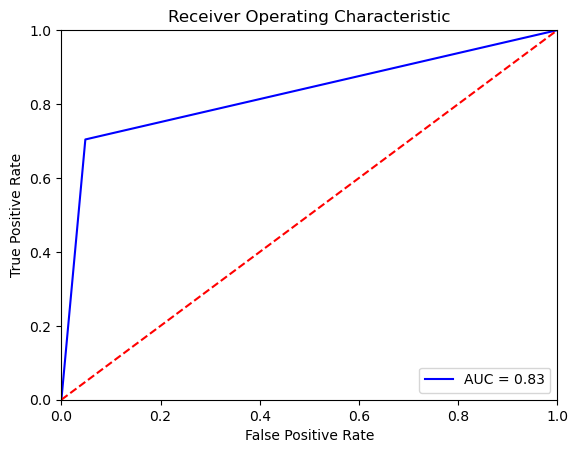

In [82]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### MLP Classifier

##### Entrenamiento

In [83]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(random_state=0, max_iter=25))])

In [84]:
train_pipeline.fit(balanced_df.drop(["Target"], axis=1), balanced_df["Target"])

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=25, random_state=0))])

##### Evaluacion

In [85]:
y_pred  = train_pipeline.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [86]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96    136343
         1.0       0.08      0.83      0.15      1102

    accuracy                           0.92    137445
   macro avg       0.54      0.88      0.56    137445
weighted avg       0.99      0.92      0.95    137445



In [87]:
confusion_matrix(test_labels, y_pred)

array([[126152,  10191],
       [   186,    916]])

In [88]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                            126152   
Programa Herencias                                  186   

                       Predicción Programa Herencias  
No Programa Herencias                          10191  
Programa Herencias                               916  


In [89]:
accuracy_score(test_labels, y_pred)

0.924500709374659

In [90]:
roc_auc_score(test_labels, y_pred)

0.878235329752377

In [91]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

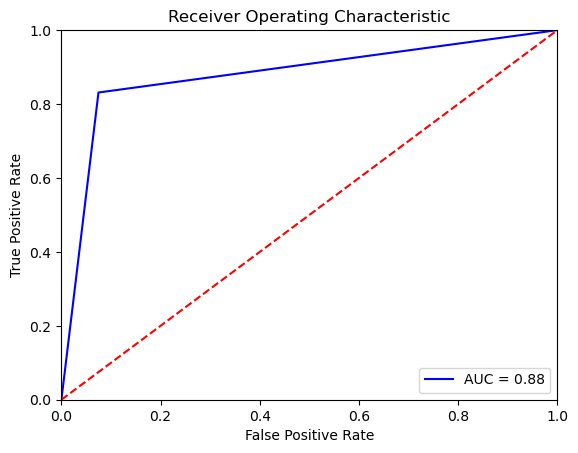

In [92]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Conclusiones 
- Balanceando eliminando registros de la clase mayoritaria, sirve para aumentar el recall de si tiene programa herencias. Es decir en nuestro caso, detectamos mejor los que tienen herencias y añadimos muchisimos socios potenciales a nuestro modelo.
- Con este enfoque ya funciona mejor los clasificadores Random Forest y MLP Classifier ya que pueden evaluar de una manera más precisa cada socio

### Añadir registros clase minoritaria SMOTE

#### Generamos dataset

In [93]:
def create_training_sets_SMOTE(data, list_columns):
    """
    Convert data frame to train, validation and test
    params:
        data: The dataframe with the dataset to be split
    Returns:
        train_features: Training feature dataset
        test_features: Test feature dataset 
        train_labels: Labels for the training dataset
        test_labels: Labels for the test dataset
        val_features: Validation feature dataset
        val_labels: Labels for the validation dataset
    """
    # Extract the target variable from the dataframe and convert the type to float32
    ys = np.array(data["cnt_programaherencias"]).astype("float32")
    
    # Drop all the unwanted columns including the target column
    # drop_list = ["cnt_id"]
    
    # Drop the columns from the drop_list and convert the data into a NumPy array of type float32
    xs = np.array(data[list_columns]).astype("float32")
    
    np.random.seed(0)
    
    # Escalar las variables
    scaler = StandardScaler()
    xs_std = scaler.fit_transform(xs)
    
    sm = SMOTE(random_state=35)
    X_res, y_res = sm.fit_resample(xs_std, ys)
    
    print(X_res.shape)
    print(y_res.shape)
    
    smote_df = pd.DataFrame(X_res, columns = list_columns) 
    smote_df['Target'] = y_res
    
    # # Use the sklearn function train_test_split to split the dataset in the ratio train 80% and test 20%
    # train_features, test_features, \
    # train_labels, test_labels = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res)
    
    
    return smote_df

In [94]:
smote_df = create_training_sets_SMOTE(df_preprocessed, variables_salida_bal) 
print('SMOTE class split')
smote_hist = np.histogram(smote_df["Target"].values, bins=2)[0]
print(smote_hist)
print(smote_hist[1]*1. / (smote_hist[0] + smote_hist[1]))

(1363428, 95)
(1363428,)
SMOTE class split
[681714 681714]
0.5


#### REGRESIÓN LOGÍSTICA

##### Entrenamiento

In [95]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('lf', LogisticRegression(random_state = 0))])

In [96]:
train_pipeline.fit(smote_df.drop(["Target"], axis=1), smote_df["Target"])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()),
                ('lf', LogisticRegression(random_state=0))])

##### Evaluacion

In [97]:
y_pred  = train_pipeline.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [98]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    136343
         1.0       0.22      0.29      0.25      1102

    accuracy                           0.99    137445
   macro avg       0.61      0.64      0.62    137445
weighted avg       0.99      0.99      0.99    137445



In [99]:
confusion_matrix(test_labels, y_pred)

array([[135231,   1112],
       [   786,    316]])

In [100]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                            135231   
Programa Herencias                                  786   

                       Predicción Programa Herencias  
No Programa Herencias                           1112  
Programa Herencias                               316  


In [101]:
accuracy_score(test_labels, y_pred)

0.9861908399723526

In [102]:
roc_auc_score(test_labels, y_pred)

0.6392977301175922

In [103]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

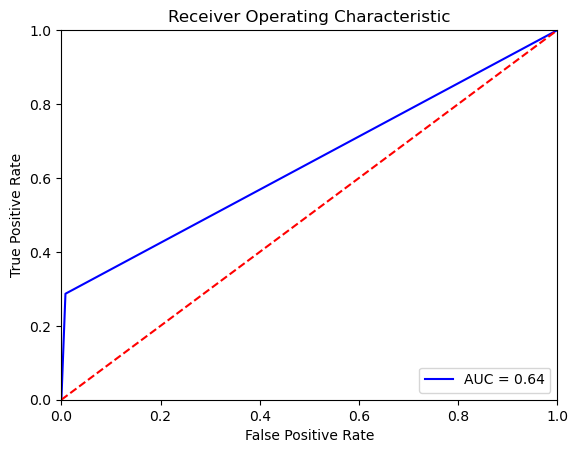

In [104]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### NB

##### Entrenamiento

In [105]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('gb', GaussianNB())])

In [106]:
train_pipeline.fit(smote_df.drop(["Target"], axis=1), smote_df["Target"])

Pipeline(steps=[('scaler', StandardScaler()), ('gb', GaussianNB())])

##### Evaluacion

In [107]:
y_pred  = train_pipeline.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [108]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    136343
         1.0       0.00      0.00      0.00      1102

    accuracy                           0.99    137445
   macro avg       0.50      0.50      0.50    137445
weighted avg       0.98      0.99      0.99    137445



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
confusion_matrix(test_labels, y_pred)

array([[136343,      0],
       [  1102,      0]])

In [110]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                            136343   
Programa Herencias                                 1102   

                       Predicción Programa Herencias  
No Programa Herencias                              0  
Programa Herencias                                 0  


In [111]:
accuracy_score(test_labels, y_pred)

0.9919822474444323

In [112]:
roc_auc_score(test_labels, y_pred)

0.5

In [113]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

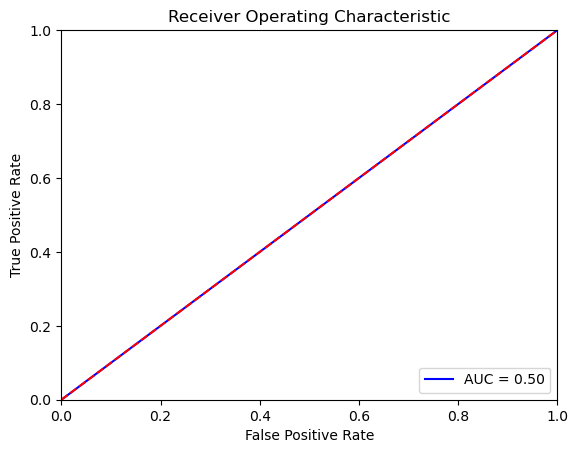

In [114]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### RF Classifier

##### Entrenamiento

In [115]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(max_depth=2, random_state=0))])

In [116]:
train_pipeline.fit(smote_df.drop(["Target"], axis=1), smote_df["Target"])

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(max_depth=2, random_state=0))])

##### Evaluacion

In [117]:
y_pred  = train_pipeline.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [118]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    136343
         1.0       0.01      1.00      0.02      1102

    accuracy                           0.01    137445
   macro avg       0.00      0.50      0.01    137445
weighted avg       0.00      0.01      0.00    137445



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [119]:
confusion_matrix(test_labels, y_pred)

array([[     0, 136343],
       [     0,   1102]])

In [120]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                                 0   
Programa Herencias                                    0   

                       Predicción Programa Herencias  
No Programa Herencias                         136343  
Programa Herencias                              1102  


In [121]:
accuracy_score(test_labels, y_pred)

0.008017752555567682

In [122]:
roc_auc_score(test_labels, y_pred)

0.5

In [123]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

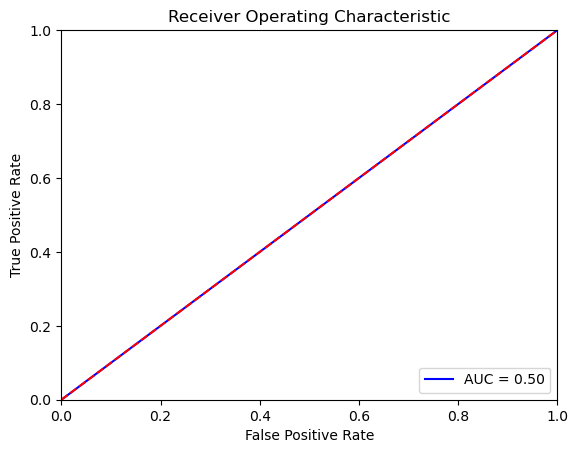

In [124]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### MLP Classifier

##### Entrenamiento

In [125]:
train_pipeline = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(random_state=0, max_iter=25))])

In [126]:
train_pipeline.fit(smote_df.drop(["Target"], axis=1), smote_df["Target"])

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=25, random_state=0))])

##### Evaluacion

In [127]:
y_pred  = train_pipeline.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [128]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.19      0.31    136343
         1.0       0.01      0.96      0.02      1102

    accuracy                           0.19    137445
   macro avg       0.50      0.57      0.17    137445
weighted avg       0.99      0.19      0.31    137445



In [129]:
confusion_matrix(test_labels, y_pred)

array([[ 25226, 111117],
       [    48,   1054]])

In [130]:
conf=pd.DataFrame(
    confusion_matrix(test_labels, y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['No Programa Herencias', 'Programa Herencias']
)
print(conf)

                       Predicción No Programa Herencias  \
No Programa Herencias                             25226   
Programa Herencias                                   48   

                       Predicción Programa Herencias  
No Programa Herencias                         111117  
Programa Herencias                              1054  


In [131]:
accuracy_score(test_labels, y_pred)

0.19120375422896432

In [132]:
roc_auc_score(test_labels, y_pred)

0.5707307486870581

In [133]:
fpr, tpr, threshold = roc_curve(test_labels, y_pred)
roc_auc = roc_auc_score(test_labels, y_pred)

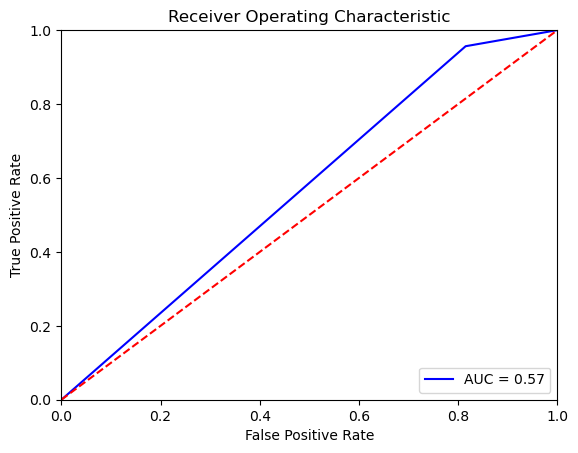

In [134]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Conclusiones 
- Balanceando añadiendo registros de la clase minoritaria, en nuestro caso ha empeorado el modelo, ya que ha hecho que siempre diga que tiene programa herencias
- Esto es debido a que el dato es menos rico, y para los clasificadores es más sencillo decir que no lo tiene.
- Este enfoque no sirve para mejorar nuestro modelo

### Hiperparametros modelo balanceado
- La búsqueda del modelo más óptimo consiste en ir probando combinaciones de parámetros, buscando la más óptima para nuestro caso de uso
- Generamos una serie de parámetros
- Evaluamos los 4 clasificadores anteriormente comentados

#### REGRESIÓN LOGÍSTICA

##### Asignación hiperparámetros

In [135]:
hyp_pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('pca', decomposition.PCA()),
                           ('logistic_Reg', LogisticRegression())])

In [136]:
aux_n_cmp = int(round(balanced_df.drop(["Target"], axis=1).shape[1]/4,0))
n_components = [aux_n_cmp,balanced_df.drop(["Target"], axis=1).shape[1]]
C = np.logspace(-4, 4, 5)
penalty = ['l2']
solver = ['lbfgs', 'sag']
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty,
                  logistic_Reg__solver=solver)

##### Búsqueda de mejor modelo

In [137]:
%%capture --no-display
clf_GS = GridSearchCV(hyp_pipe, parameters)
clf_GS.fit(balanced_df.drop(["Target"], axis=1), balanced_df["Target"])

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic_Reg', LogisticRegression())]),
             param_grid={'logistic_Reg__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'logistic_Reg__penalty': ['l2'],
                         'logistic_Reg__solver': ['lbfgs', 'sag'],
                         'pca__n_components': [24, 95]})

In [138]:
print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print('Best Solver:', clf_GS.best_estimator_.get_params()['logistic_Reg__solver'])
print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

Best Penalty: l2
Best C: 100.0
Best Number Of Components: 95
Best Solver: lbfgs

LogisticRegression(C=100.0)


##### Evaluacion

In [139]:
y_pred  = clf_GS.best_estimator_.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [140]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    136343
         1.0       0.06      0.85      0.12      1102

    accuracy                           0.90    137445
   macro avg       0.53      0.87      0.53    137445
weighted avg       0.99      0.90      0.94    137445



In [141]:
confusion_matrix(test_labels, y_pred)

array([[122618,  13725],
       [   168,    934]])

#### NB

##### Asignación hiperparámetros

In [142]:
hyp_pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('pca', decomposition.PCA()),
                           ('nb', GaussianNB())])

In [143]:
aux_n_cmp = int(round(balanced_df.drop(["Target"], axis=1).shape[1]/4,0))
n_components = [aux_n_cmp,balanced_df.drop(["Target"], axis=1).shape[1]]
var_smoothing= [1e-11, 1e-10, 1e-9]
parameters = dict(pca__n_components=n_components,
                      nb__var_smoothing=var_smoothing)

In [144]:
%%capture --no-display
nb_GS = GridSearchCV(hyp_pipe, parameters)
nb_GS.fit(balanced_df.drop(["Target"], axis=1), balanced_df["Target"])

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA()), ('nb', GaussianNB())]),
             param_grid={'nb__var_smoothing': [1e-11, 1e-10, 1e-09],
                         'pca__n_components': [24, 95]})

##### Búsqueda de mejor modelo

In [145]:
print('Best Number Of Components:', nb_GS.best_estimator_.get_params()['pca__n_components'])
print('Best var_smoothing:', nb_GS.best_estimator_.get_params()['nb__var_smoothing'])
print(); print(nb_GS.best_estimator_.get_params()['nb'])

Best Number Of Components: 24
Best var_smoothing: 1e-09

GaussianNB()


##### Evaluacion

In [146]:
y_pred  = nb_GS.best_estimator_.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [147]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    136343
         1.0       0.06      0.60      0.10      1102

    accuracy                           0.91    137445
   macro avg       0.53      0.76      0.53    137445
weighted avg       0.99      0.91      0.95    137445



In [148]:
confusion_matrix(test_labels, y_pred)

array([[125052,  11291],
       [   437,    665]])

Balanceando añadiendo registros de la clase mayoritaria, sirve para aumentar el recall de si tiene programa herencias. Es decir en nuestro caso, detectamos mejor los que tienen herencias
y añadimos menos socios potenciales a nuestro modelo

#### RF Classifier

##### Asignación hiperparámetros

In [149]:
hyp_pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('pca', decomposition.PCA()),
                           ('rf', RandomForestClassifier(random_state=0))])

In [150]:
aux_n_cmp = int(round(balanced_df.drop(["Target"], axis=1).shape[1]/4,0))
n_components = [aux_n_cmp,balanced_df.drop(["Target"], axis=1).shape[1]]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
parameters = dict(pca__n_components=n_components,
                      rf__max_features=max_features,
                      rf__max_depth=max_depth,
                  rf__min_samples_split=min_samples_split,
                 rf__min_samples_leaf=min_samples_leaf,
                 rf__bootstrap=bootstrap)

##### Búsqueda de mejor modelo

In [ ]:
%%capture --no-display
rf_GS = RandomizedSearchCV(estimator=hyp_pipe, param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_GS.fit(balanced_df.drop(["Target"], axis=1), balanced_df["Target"])

In [152]:
print('Best Number Of Components:', rf_GS.best_estimator_.get_params()['pca__n_components'])
print('Best n_estimators:', rf_GS.best_estimator_.get_params()['rf__n_estimators'])
print('Best max_features:', rf_GS.best_estimator_.get_params()['rf__max_features'])
print('Best max_depth:', rf_GS.best_estimator_.get_params()['rf__max_depth'])
print('Best min_samples_split:', rf_GS.best_estimator_.get_params()['rf__min_samples_split'])
print('Best min_samples_leaf:', rf_GS.best_estimator_.get_params()['rf__min_samples_leaf'])
print('Best bootstrap:', rf_GS.best_estimator_.get_params()['rf__bootstrap'])
print(); print(rf_GS.best_estimator_.get_params()['rf'])

Best Number Of Components: 95
Best n_estimators: 100
Best max_features: auto
Best max_depth: 26
Best min_samples_split: 5
Best min_samples_leaf: 2
Best bootstrap: True

RandomForestClassifier(max_depth=26, min_samples_leaf=2, min_samples_split=5,
                       random_state=0)


##### Evaluacion

In [153]:
y_pred  = rf_GS.best_estimator_.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [154]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.94    136343
         1.0       0.06      0.86      0.12      1102

    accuracy                           0.90    137445
   macro avg       0.53      0.88      0.53    137445
weighted avg       0.99      0.90      0.94    137445



In [155]:
confusion_matrix(test_labels, y_pred)

array([[122179,  14164],
       [   157,    945]])

#### MLP Classifier

##### Asignación hiperparámetros

In [156]:
hyp_pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('pca', decomposition.PCA()),
                           ('mlp', MLPClassifier())])

In [157]:
parameters = {
    'pca__n_components': [25, 107],
    'mlp__solver': ['lbfgs'],
    'mlp__max_iter': [25, 50, 100],
    'mlp__alpha': 10.0 ** -np.arange(1,10,4),
    'mlp__hidden_layer_sizes':np.arange(10,12),
    'mlp__random_state':[0,1,2,3,4,5,6,7,8,9]
}

##### Búsqueda de mejor modelo

In [ ]:
%%capture --no-display
mlp_GS = RandomizedSearchCV(estimator=hyp_pipe, param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
mlp_GS.fit(balanced_df.drop(["Target"], axis=1), balanced_df["Target"])

In [159]:
print('Best Number Of Components:', mlp_GS.best_estimator_.get_params()['pca__n_components'])
print('Best n_estimators:', mlp_GS.best_estimator_.get_params()['mlp__solver'])
print('Best max_features:', mlp_GS.best_estimator_.get_params()['mlp__max_iter'])
print('Best max_depth:', mlp_GS.best_estimator_.get_params()['mlp__alpha'])
print('Best min_samples_split:', mlp_GS.best_estimator_.get_params()['mlp__hidden_layer_sizes'])
print('Best min_samples_leaf:', mlp_GS.best_estimator_.get_params()['mlp__random_state'])
print(); print(mlp_GS.best_estimator_.get_params()['mlp'])

Best Number Of Components: 25
Best n_estimators: lbfgs
Best max_features: 100
Best max_depth: 9.999999999999999e-06
Best min_samples_split: 11
Best min_samples_leaf: 2

MLPClassifier(alpha=9.999999999999999e-06, hidden_layer_sizes=11, max_iter=100,
              random_state=2, solver='lbfgs')


##### Evaluacion

In [160]:
y_pred  = mlp_GS.best_estimator_.predict(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [161]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    136343
         1.0       0.06      0.85      0.12      1102

    accuracy                           0.90    137445
   macro avg       0.53      0.87      0.53    137445
weighted avg       0.99      0.90      0.94    137445



In [162]:
confusion_matrix(test_labels, y_pred)

array([[122436,  13907],
       [   170,    932]])

## Modelo Final
- El modelo que mejor ha funcionado ha sido Random Forest con el dato balanceado por abajo
- Se han ajustado hiperparametros
- En este paso se guardará el modelo en pickle

In [163]:
final_model = rf_GS.best_estimator_

### Evaluacion Todo Dataset

In [164]:
y_pred  = final_model.predict(df_preprocessed.drop(["cnt_id","cnt_programaherencias"], axis=1))

In [165]:
y_pred.shape

(687224,)

In [166]:
print(classification_report(np.array(df_preprocessed["cnt_programaherencias"]).astype("float32"), y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.94    681714
         1.0       0.06      0.89      0.12      5510

    accuracy                           0.89    687224
   macro avg       0.53      0.89      0.53    687224
weighted avg       0.99      0.89      0.94    687224



In [167]:
confusion_matrix(np.array(df_preprocessed["cnt_programaherencias"]).astype("float32"), y_pred)

array([[610171,  71543],
       [   626,   4884]])

In [168]:
conf=pd.DataFrame(
    confusion_matrix(np.array(df_preprocessed["cnt_programaherencias"]).astype("float32"), y_pred),
    columns=['Predicción No Programa Herencias', 'Predicción Programa Herencias'],
    index  =['Verdadero No Programa Herencias', 'Verdadero Programa Herencias']
)
print(conf)

                                 Predicción No Programa Herencias  \
Verdadero No Programa Herencias                            610171   
Verdadero Programa Herencias                                  626   

                                 Predicción Programa Herencias  
Verdadero No Programa Herencias                          71543  
Verdadero Programa Herencias                              4884  


In [169]:
accuracy_score(np.array(df_preprocessed["cnt_programaherencias"]).astype("float32"), y_pred)

0.8949847502415516

In [170]:
roc_auc_score(np.array(df_preprocessed["cnt_programaherencias"]).astype("float32"), y_pred)

0.8907213078540736

In [171]:
fpr, tpr, threshold = roc_curve(np.array(df_preprocessed["cnt_programaherencias"]).astype("float32"), y_pred)
roc_auc = roc_auc_score(np.array(df_preprocessed["cnt_programaherencias"]).astype("float32"), y_pred)

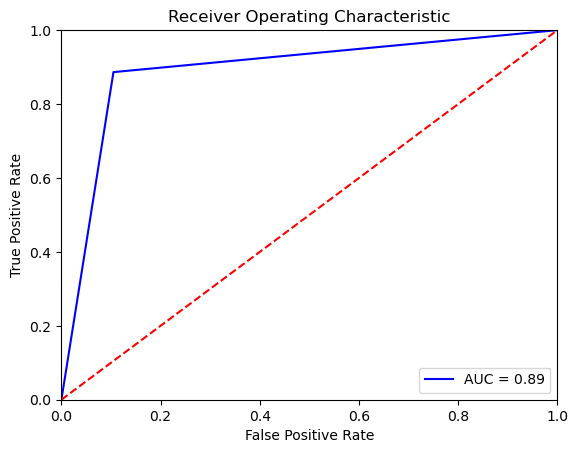

In [172]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Guardar modelo

In [173]:
pickle.dump(final_model, open('classifier_final.pkl', 'wb'))